# HuBMAP - Efficient Sampling Ensemble (deepflash2, pytorch, fastai) [train]

> Kernel for model training with efficient region based sampling.

Requires deepflash2 (git version), zarr, and segmentation-models-pytorch


## Overview

1. Installation and package loading
2. Helper functions and patches
3. Configuration
4. Training

### Inputs
- https://www.kaggle.com/matjes/hubmap-zarr converted images (downscaled with factor 2)
- https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01 masks and weights for sampling

### Versions
- V7: Fixed augmentations in deepflash2 `RandomTileDataset` config (random zoom) - LB 0.913
- V8: Adding *albumentations* transforms, switching to Cross-entropy loss

## Motivation

### Background

A glomerulus is a network of small blood vessels located at the beginning of a nephron in the kidney ([Wikipedia](https://en.wikipedia.org/wiki/Glomerulus_(kidney))
)). Glomeruli are mainly found in the renal **cortex**, while the renal **medulla** contains mainly the renal tubule. Since we are dealing with biological structures, the separation is not not absolute and the transitions are not always perfectly sharp.

![Diagram of a nephron](http://s3-us-west-2.amazonaws.com/courses-images/wp-content/uploads/sites/1842/2017/05/26234530/m9skcbftjqzrokkkopam.png)
[Diagram of a nephron from libretexts.org, Introductory and General Biology](https://bio.libretexts.org/Bookshelves/Introductory_and_General_Biology/Book%3A_General_Biology_(Boundless)/41%3A_Osmotic_Regulation_and_the_Excretory_System/41.4%3A_Human_Osmoregulatory_and_Excretory_Systems/41.4B%3A_Nephron%3A_The_Functional_Unit_of_the_Kidney)

### Key Idea

A common approach to deal with the very large (>500MB - 5GB) TIFF files in the dataset is to decompose the images in smaller patches/tiles, for instance by using a sliding window apporach.
> **Knowing that the glomeruli are mainly found in the cortex, we should focus on this region during training**. 

Instead of preprocessing the images and saving them into fixed tiles, we sample tiles from the entire images with a higher probability on tiles that contain glumeroli and cortex. Have a look at [this kernel](https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01) for more details.


## Advantages of this approach

In combination with [deepflash2](https://github.com/matjesg/deepflash2/tree/master/) and the deepflash2 [pytorch datasets](https://matjesg.github.io/deepflash2/data.html#Datasets) in particular, this approach has several advantages:
- no preprocessing of the data (only saving them to .zarr files for memory efficient loading)
    - flexible tile shapes (input shapes, e.g. 1024, 512, 256) at runtime
    - flexible scaling (e.g., by facors of 2,3,4)
- faster convergence during traing (~30 min for training a competitive model)
    - focusing on the relevant regions (e.g., tiles that contain glumeroli and cortex)
    - "additional" data augmentation from random sampling (compared to fixed windows)

### Installation and package loading

In [1]:
!pip install -q ../input/deepflash2-lfs
!git clone https://github.com/qubvel/segmentation_models.pytorch.git
!pip install -q ./segmentation_models.pytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Cloning into 'segmentation_models.pytorch'...
remote: Enumerating objects: 1517, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1517 (delta 142), reused 136 (delta 87), pack-reused 1277
Receiving objects: 100% (1517/1517), 4.90 MiB | 8.44 MiB/s, done.
Resolving deltas: 100% (825/825), done.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# imports
import zarr, cv2, random, torch
import numpy as np, pandas as pd
import albumentations as A
import segmentation_models_pytorch as smp
from fastai.vision.all import *
from deepflash2.all import *
from scipy import interpolate
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
from hubmap_loss_metrics import *

## Helper functions and patches

In [3]:
# Patch for deepflash2 'DeformationField' class, see https://fastcore.fast.ai/basics.html#patch
@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [4]:
class HubmapRandomTileDataset(Dataset):
    """
    Pytorch Dataset that creates random tiles with augmentations from the input images.
    """
    n_inp = 1
    def __init__(self, 
                 files,
                 label_path,
                 cdf_path, 
                 df_stats, 
                 sample_multiplier=50,
                 tile_shape = (512,512),
                 scale = 1,
                 flip = True,                                
                 rotation_range_deg = (0, 360),     
                 deformation_grid = (150,150), 
                 deformation_magnitude = (10,10),
                 value_minimum_range = (0, 0), 
                 value_maximum_range = (1, 1), 
                 value_slope_range = (1, 1),
                 albumentations_tfms=None,
                 **kwargs
                ):
        store_attr('files, df_stats, sample_multiplier, tile_shape, scale, albumentations_tfms')
        store_attr('flip, rotation_range_deg, deformation_grid, deformation_magnitude, value_minimum_range, value_maximum_range, value_slope_range')
        
        self.data = zarr.open_group(self.files[0].parent.as_posix(), mode='r')
        self.labels = zarr.open_group(label_path)
        self.cdfs = zarr.open_group(cdf_path)
        
        self.indices = []
        self.center_indices = []
        self.df_stats = self.df_stats[self.df_stats.index.isin([f.stem for f in self.files],  level=0)]
        print('Preparing sampling')
        for key, grp in self.df_stats.groupby('idx'):
            for (idx, i), row in grp.iterrows():
                self.indices.append(idx)
                self.center_indices.append(i)
            for _ in range(self.sample_multiplier):
                self.indices.append(idx)
                self.center_indices.append(None)         
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx): idx = idx.tolist()       
        file_name = self.indices[idx]
        center_idx = self.center_indices[idx]

        img = self.data[file_name]
        n_channels = img.shape[-1]

        lbl = self.labels[file_name]
        cdf = self.cdfs[file_name]

        center = self.random_center(cdf[:], lbl.shape, scale=512, file=file_name, center_idx=center_idx)
        X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
        Y = self.deformationField.apply(lbl, center, (0,0), 0)

        if self.albumentations_tfms:
            augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
            X = (augmented['image']/255)
            Y = augmented['mask']

        X = X.transpose(2, 0, 1).astype('float32')
        Y = Y.astype('int64')
        
        return  TensorImage(X), TensorMask(Y)
        
    def random_center(self, cdf, orig_shape, file, center_idx, scale=512):
        'Sample random center'
        if center_idx:
            stats = self.df_stats.loc[file, center_idx]
            cx = random.randrange(stats.top, stats.top+stats.height)
            cy = random.randrange(stats.left, stats.left+stats.width)
        else:
            scale_y = int((orig_shape[1]/orig_shape[0])*scale)
            cx, cy = np.unravel_index(np.argmax(cdf > np.random.random()), (scale,scale_y))
            cx = int(cx*orig_shape[0]/scale)
            cy = int(cy*orig_shape[1]/scale_y)
        return cx, cy
        
    def on_epoch_end(self, verbose=True):

        if verbose: print("Generating deformation field")
        self.deformationField = DeformationField(self.tile_shape, self.scale)

        if self.rotation_range_deg[1] > self.rotation_range_deg[0]:
            self.deformationField.rotate(
                theta=np.pi * (np.random.random()
                            * (self.rotation_range_deg[1] - self.rotation_range_deg[0])
                            + self.rotation_range_deg[0])
                            / 180.0)

        if self.flip:
            self.deformationField.mirror(np.random.choice((True,False),2))

        if self.deformation_grid is not None:
            self.deformationField.addRandomDeformation(
                self.deformation_grid, self.deformation_magnitude)

        if verbose: print("Generating value augmentation function")
        minValue = (self.value_minimum_range[0]
            + (self.value_minimum_range[1] - self.value_minimum_range[0])
            * np.random.random())

        maxValue = (self.value_maximum_range[0]
            + (self.value_maximum_range[1] - self.value_maximum_range[0])
            * np.random.random())

        intermediateValue = 0.5 * (
            self.value_slope_range[0]
            + (self.value_slope_range[1] - self.value_slope_range[0])
            * np.random.random())

        self.gammaFcn = interpolate.interp1d([0, 0.5, 1.0], [minValue, intermediateValue, maxValue], kind="quadratic")  
        

In [5]:
class HubmapValidationDataset(Dataset):
    "Pytorch Dataset that creates random tiles for validation and prediction on new data."
    n_inp = 1
    def __init__(self, 
                 files, 
                 label_path, 
                 tile_shape = (512,512),
                 scale=1,
                 val_length=None, 
                 val_seed=42, 
                 **kwargs
                ):
        store_attr('files, label_path, tile_shape, scale, val_seed')
        self.data = zarr.open_group(self.files[0].parent.as_posix())
        self.labels = zarr.open_group(label_path)
        self.output_shape = self.tile_shape
        self.tiler = DeformationField(self.tile_shape, scale=self.scale)
        self.image_indices = []
        self.image_shapes = []
        self.centers = []
        self.valid_indices = None

        j = 0
        for i, file in enumerate(progress_bar(self.files, leave=False)):
            img = self.data[file.name]
            
            # Tiling
            data_shape = tuple(int(x//self.scale) for x in img.shape[:-1])
            start_points = [o//2 for o in self.output_shape]
            end_points = [(s - st) for s, st in zip(data_shape, start_points)]
            n_points = [int((s)//(o))+1 for s, o in zip(data_shape, self.output_shape)]
            center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
            for cx in center_points[1]:
                for cy in center_points[0]:
                    self.centers.append((int(cy*self.scale), int(cx*self.scale)))
                    self.image_indices.append(i)
                    self.image_shapes.append(data_shape)
                    j += 1
        
        if val_length:
            if val_length>len(self.image_shapes):
                print(f'Reducing validation from lenght {val_length} to {len(self.image_shapes)}')
                val_length = len(self.image_shapes)
            np.random.seed(self.val_seed)
            choice = np.random.choice(len(self.image_indices), val_length, replace=False)
            self.valid_indices = {i:idx for i, idx in  enumerate(choice)}

    def __len__(self):
        if self.valid_indices: return len(self.valid_indices)
        else: return len(self.image_shapes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.valid_indices: idx = self.valid_indices[idx]
        img_path = self.files[self.image_indices[idx]]
        img = self.data[img_path.name]
        centerPos = self.centers[idx]
        X = self.tiler.apply(img, centerPos)       
        X = X.transpose(2, 0, 1).astype('float32')
        
        lbl = self.labels[img_path.name]
        Y = self.tiler.apply(lbl, centerPos, (0,0), order=0).astype('int64')
        
        return  TensorImage(X), TensorMask(Y)   

In [6]:
def show_batch(batch):
    fig, axs = plt.subplots(4,4, figsize=(20,20))   
    images = batch[0].cpu().numpy()
    labels = batch[1].cpu().numpy()

    for i in range(16):     
        axs[i%4, i//4].imshow(images[i, 1])
        axs[i%4, i//4].imshow(labels[i], alpha=0.5)
    plt.show()
    
    plt.hist(batch[0][:,0].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,1].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,2].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.show()
    


Loss

In [7]:
dc = TorchLoss(smp.losses.DiceLoss(mode='multiclass', classes=[1]))
ce = CrossEntropyLossFlat(axis=1) #TorchLoss(smp.losses.SoftCrossEntropyLoss(smooth_factor=0.))

### Config

In [8]:
class CONFIG():
    # paths
    path = Path('../input/hubmap-kidney-segmentation')
    data_path = Path('../input/hubmap-zarr-test/images_scale2')
    # annotations_path = Path('../input/hubmap-more-efficient-sampling-deepflash2/masks_scale2')
    annotations_path = Path('../input/hubmap-efficient-sampling-ii-deepflash2-test/masks_scale2')
    
    # deepflash2 dataset
    scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (512, 512)
    sample_multiplier = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.61561477, 0.4379893 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])
        
    # pytorch model (segmentation_models_pytorch)
    encoder_name = "efficientnet-b2"
    encoder_weights = 'imagenet'
    in_channels = 3
    classes = 2
    
    # Training
    n_splits = 5
    mixed_precision_training = True
    batch_size = 16
    weight_decay = 0.00
    loss_func = JointLoss(dc, ce, 1, 1)
    metrics = [Dice(), Iou(), Recall(), Precision()]
    max_learning_rate = 1e-3
    epochs = 10
    
cfg = CONFIG()

# Albumentations augmentations
tfms = A.Compose([
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
        ], p=0.3),
    A.OneOf([
        A.Blur(blur_limit=3, p=1),
        A.MedianBlur(blur_limit=3, p=1)
    ], p=.1),
    A.OneOf([
        A.GaussNoise(0.002, p=.5),
        A.IAAAffine(p=.5),
    ], p=.1),
    # Additional position augmentations
    A.RandomRotate90(p=.5),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Cutout(num_holes=10,fill_value=255, 
             max_h_size=int(.1 * cfg.tile_shape[0]), 
             max_w_size=int(.1 * cfg.tile_shape[0]), 
             p=.1),
])

# Position Augmentations
position_augmentation_kwargs = {
    'flip':True,                                
    'rotation_range_deg':(0, 360),     
    'deformation_grid': (150,150), 
    'deformation_magnitude':(10,10),
    'value_minimum_range':(0, 0), 
    'value_maximum_range':(1, 1), 
    'value_slope_range':(1, 1)}

# Datasets
ds_kwargs = {
    'label_path': (cfg.annotations_path/'labels').as_posix(),
    'cdf_path': (cfg.annotations_path/'cdfs').as_posix(),
    'df_stats': pd.read_csv(cfg.annotations_path/'roi_stats.csv', index_col=[0,1]),
    'tile_shape':cfg.tile_shape,
    'scale': cfg.scale,
    'val_length':cfg.val_length, 
    'sample_multiplier':cfg.sample_multiplier,
    'albumentations_tfms': tfms
}


In [9]:
df_train = pd.read_csv(cfg.path/'train.csv')
df_info = pd.read_csv(cfg.path/'HuBMAP-20-dataset_information.csv')
files = L([cfg.data_path/x for x in df_train.id])
files

(#15) [Path('../input/hubmap-zarr-test/images_scale2/2f6ecfcdf'),Path('../input/hubmap-zarr-test/images_scale2/8242609fa'),Path('../input/hubmap-zarr-test/images_scale2/aaa6a05cc'),Path('../input/hubmap-zarr-test/images_scale2/cb2d976f4'),Path('../input/hubmap-zarr-test/images_scale2/b9a3865fc'),Path('../input/hubmap-zarr-test/images_scale2/b2dc8411c'),Path('../input/hubmap-zarr-test/images_scale2/0486052bb'),Path('../input/hubmap-zarr-test/images_scale2/e79de561c'),Path('../input/hubmap-zarr-test/images_scale2/095bf7a1f'),Path('../input/hubmap-zarr-test/images_scale2/54f2eec69')...]

## Training

Validating on ['2f6ecfcdf', '54f2eec69', '26dc41664']
Preparing sampling
Generating deformation field
Generating value augmentation function


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

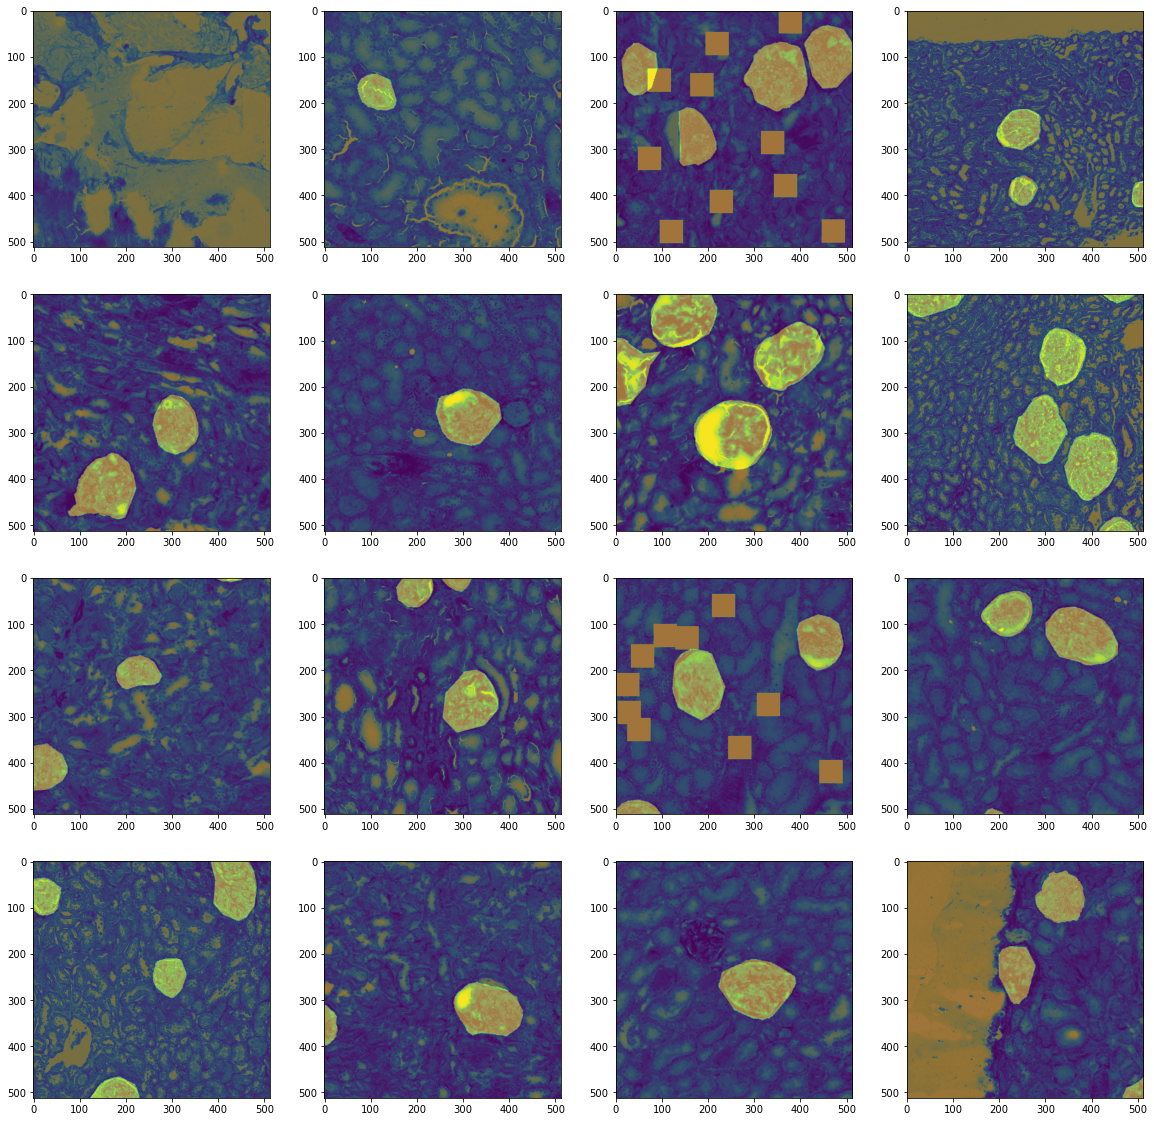

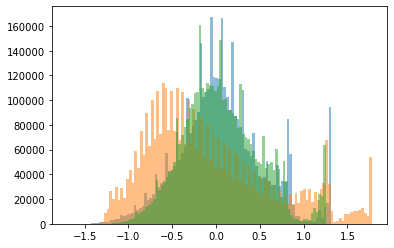

epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,0.597890,0.733256,0.904842,0.826221,0.919990,0.890185,08:18
1,0.123373,0.151179,0.924305,0.859264,0.926970,0.921655,07:07
2,0.096653,0.093176,0.936673,0.880888,0.922114,0.951698,07:18
3,0.086754,0.089836,0.936199,0.880051,0.924642,0.948049,07:09
4,0.087146,0.088543,0.937834,0.882944,0.931701,0.944047,07:11
5,0.083893,0.076674,0.943287,0.892661,0.946612,0.939985,07:26
6,0.078127,0.078359,0.940342,0.887401,0.939142,0.941544,07:11
7,0.075168,0.077856,0.940279,0.887290,0.931495,0.949231,07:33
8,0.073131,0.077532,0.941076,0.888710,0.934808,0.947429,07:23
9,0.073365,0.077688,0.940579,0.887824,0.933176,0.948101,07:26


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.9048420191982641.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.9243052931990281.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9366727238182465.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.9378337547159133.
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.9432867872017918.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augment

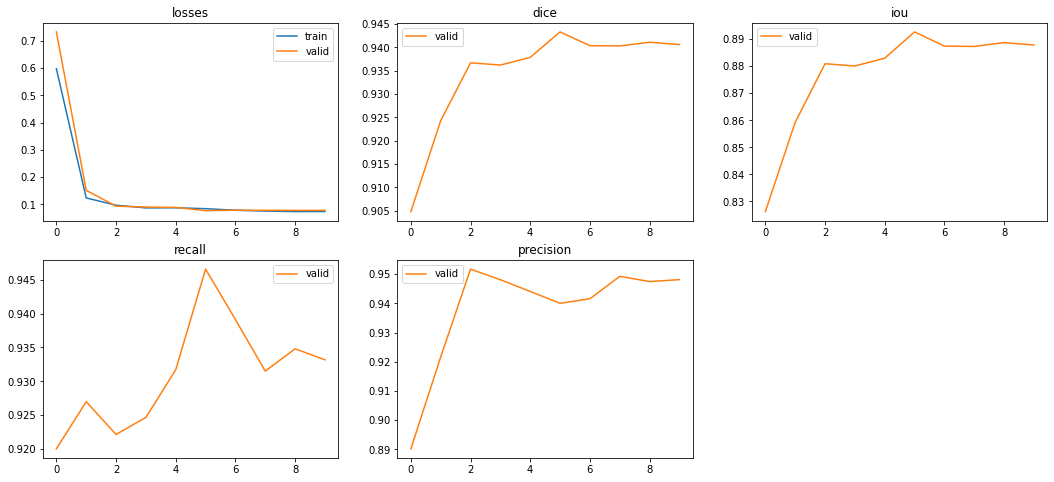

Validating on ['b2dc8411c', '095bf7a1f', 'afa5e8098']
Preparing sampling
Generating deformation field
Generating value augmentation function


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,0.507528,0.494021,0.882860,0.790286,0.925193,0.844232,07:17
1,0.122108,0.152628,0.900023,0.818220,0.946199,0.858144,07:03
2,0.094598,0.117658,0.912541,0.839150,0.899191,0.926293,07:11
3,0.094267,0.105264,0.919841,0.851580,0.882337,0.960675,07:17
4,0.082361,0.097393,0.923468,0.857817,0.889206,0.960476,07:11
5,0.080469,0.087610,0.929512,0.868307,0.914301,0.945238,07:03
6,0.077777,0.088457,0.928012,0.865692,0.916981,0.939311,07:09
7,0.072420,0.084488,0.932697,0.873882,0.917879,0.948001,07:08
8,0.072098,0.087998,0.928615,0.866743,0.909650,0.948388,06:59
9,0.069588,0.086812,0.929831,0.868864,0.912579,0.947748,07:11


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.8828601210488468.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.9000230938063138.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9125408776332801.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.9198412405795138.
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.9234679787542196.
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.9295120040891449.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 7 with dice value: 0.93269

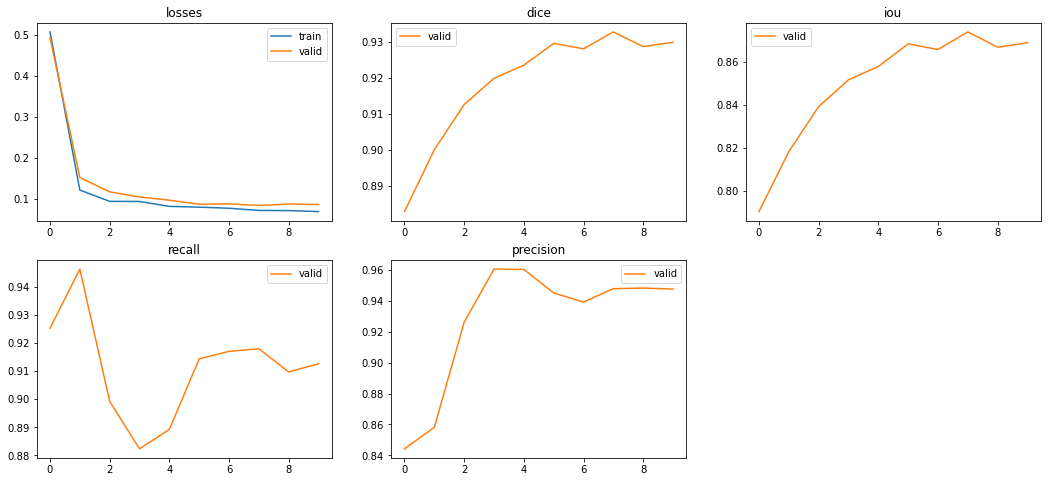

Validating on ['8242609fa', 'aaa6a05cc', '1e2425f28']
Preparing sampling
Generating deformation field
Generating value augmentation function


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,0.729114,0.688146,0.897188,0.813546,0.890809,0.903659,06:56
1,0.135371,0.118165,0.936100,0.879875,0.950610,0.922025,06:58
2,0.103535,0.080055,0.944817,0.895406,0.941573,0.948084,06:55
3,0.097535,0.080588,0.939050,0.885103,0.933538,0.944628,06:45
4,0.090233,0.072973,0.945449,0.896543,0.947419,0.943488,07:01
5,0.084719,0.070474,0.946360,0.898182,0.951735,0.941045,06:36
6,0.079799,0.070581,0.945336,0.896339,0.946816,0.943861,07:01
7,0.077679,0.071487,0.945313,0.896298,0.949575,0.941090,07:03
8,0.073608,0.071114,0.945512,0.896655,0.951679,0.939425,07:08
9,0.075265,0.070022,0.946172,0.897843,0.952539,0.939889,06:43


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.8971880070078927.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.9360995179440836.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9448171523391372.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.9454494467929025.
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.9463599780578349.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augment

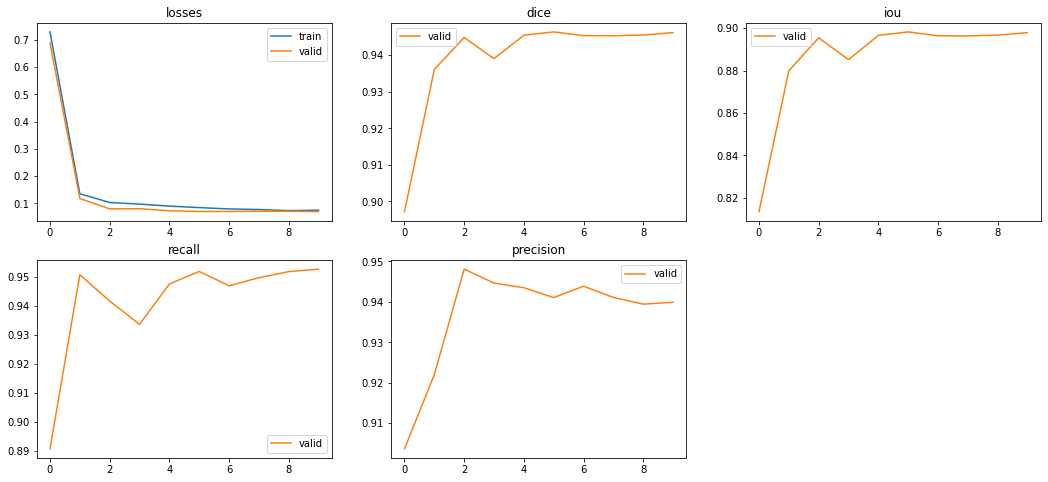

Validating on ['b9a3865fc', 'e79de561c', '4ef6695ce']
Preparing sampling
Generating deformation field
Generating value augmentation function


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.407302,1.269828,0.798069,0.663989,0.890909,0.722753,06:20
1,0.239036,0.240979,0.921250,0.853998,0.935758,0.907185,06:21
2,0.108640,0.106439,0.934175,0.876481,0.951883,0.917115,06:21
3,0.090890,0.095018,0.933008,0.874429,0.939985,0.926135,06:19
4,0.086712,0.089388,0.935027,0.877983,0.933453,0.936607,06:24
5,0.082775,0.086008,0.937733,0.882767,0.939478,0.935995,06:37
6,0.079918,0.089075,0.934986,0.877909,0.934383,0.935589,06:37
7,0.075581,0.084302,0.938815,0.884686,0.943479,0.934198,06:38
8,0.074633,0.084076,0.938385,0.883923,0.937295,0.939478,06:30
9,0.072183,0.085152,0.937450,0.882264,0.936285,0.938617,06:34


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.7980693314615381.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.9212499718687622.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9341754714592788.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.9350274184112334.
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.9377334111225599.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 7 with dice value: 0.9388154324999104.
Generating deformation field
Generating value augmenta

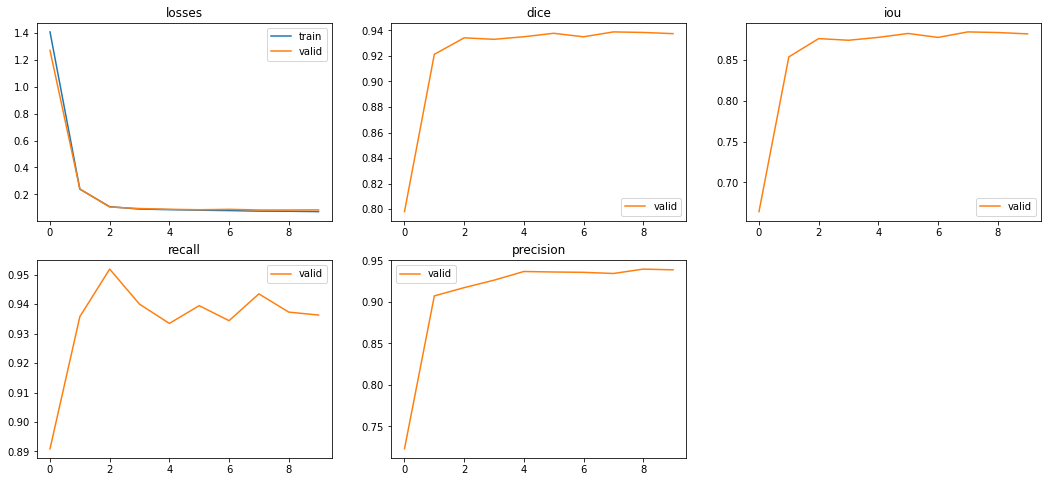

Validating on ['cb2d976f4', '0486052bb', 'c68fe75ea']
Preparing sampling
Generating deformation field
Generating value augmentation function


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,0.516027,0.649760,0.856100,0.748405,0.921324,0.799500,07:30
1,0.122618,0.177417,0.899083,0.816667,0.880687,0.918263,07:23
2,0.096863,0.148400,0.901341,0.820402,0.855997,0.951759,07:26
3,0.089061,0.138457,0.901707,0.821007,0.896324,0.907154,07:38
4,0.086492,0.118955,0.914367,0.842243,0.932789,0.896658,07:31
5,0.081254,0.125592,0.910314,0.835392,0.915385,0.905299,07:26
6,0.076527,0.121689,0.913351,0.840521,0.901289,0.925741,07:11
7,0.073992,0.116603,0.913359,0.840534,0.901532,0.925501,07:16
8,0.072748,0.115971,0.913897,0.841446,0.904747,0.923234,07:11
9,0.071865,0.115051,0.914208,0.841974,0.904387,0.924245,07:31


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.8561000131666529.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.89908262384978.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.901341426562233.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.9017066772297312.
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.9143669324744188.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentati

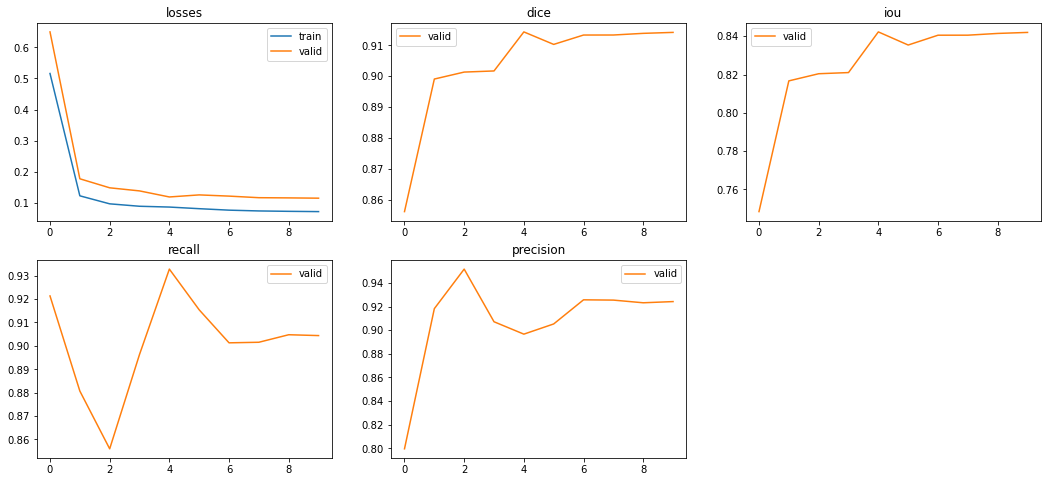

In [10]:
kf = KFold(cfg.n_splits, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(kf.split(files)):
    files_train, files_val = files[train_idx], files[val_idx]
    print('Validating on', [x.name for x in files_val])
    
    # Datasets
    train_ds = HubmapRandomTileDataset(files_train, **ds_kwargs, **position_augmentation_kwargs)
    valid_ds = HubmapValidationDataset(files_val, **ds_kwargs)
    
    # Model
    model = smp.Unet(encoder_name=cfg.encoder_name, 
                     encoder_weights=cfg.encoder_weights, 
                     in_channels=cfg.in_channels, 
                     classes=cfg.classes)
    
    # Dataloader and learner
    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    
    if i==0: show_batch(dls.one_batch())

    cbs = [SaveModelCallback(monitor='dice'), ElasticDeformCallback]
    learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
    if cfg.mixed_precision_training: learn.to_fp16()
        
    # Fit
    learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
    learn.recorder.plot_metrics()
    
    # Save Model
    state = {'model': learn.model.state_dict(), 'stats':cfg.stats}
    torch.save(state, f'unet_{cfg.encoder_name}_{i}.pth', pickle_protocol=2, _use_new_zipfile_serialization=False)